In [1]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D, Dropout
from tensorflow.keras.utils import plot_model
from keras.layers import BatchNormalization
from keras.optimizers import Adam
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pandas as pd
from keras_vggface.vggface import VGGFace
from keras.layers import Input

In [2]:
batch_size = 256
target_size = (224, 224)
input_shape=(224, 224, 3)
num_classes = 6
epochs=120

seed=1337
adam_lr = 0.001
FC = 4096
patience = 3
dense_dropout = 0.3
cnn_dropout = 0
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch=256
validation_steps=256
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model_name = 'vggface_race.h5'

In [3]:
train_data = ImageDataGenerator(rescale = 1./255,
      rotation_range=25,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_data = ImageDataGenerator( rescale = 1.0/255)

test_data = ImageDataGenerator( rescale = 1.0/255)

In [4]:
print("Training Data:")
# There are 7 different classes
train_generator = train_data.flow_from_directory('./races_/Training',
                                                    batch_size =batch_size ,
                                                    class_mode = 'categorical',
                                                    seed=seed,
                                                    target_size = target_size )     

print("Validation Data:")
validation_generator =  validation_data.flow_from_directory( './races_/Validation',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'categorical',
                                                          seed=seed,
                                                          target_size = target_size)

# print("Test Data:")
# test_generator = test_data.flow_from_directory('./races/Test',
#                                                           batch_size  = batch_size,
#                                                           class_mode  = 'categorical',
#                                                           seed=seed,
#                                                           target_size = target_size)

Training Data:
Found 75974 images belonging to 6 classes.
Validation Data:
Found 9544 images belonging to 6 classes.


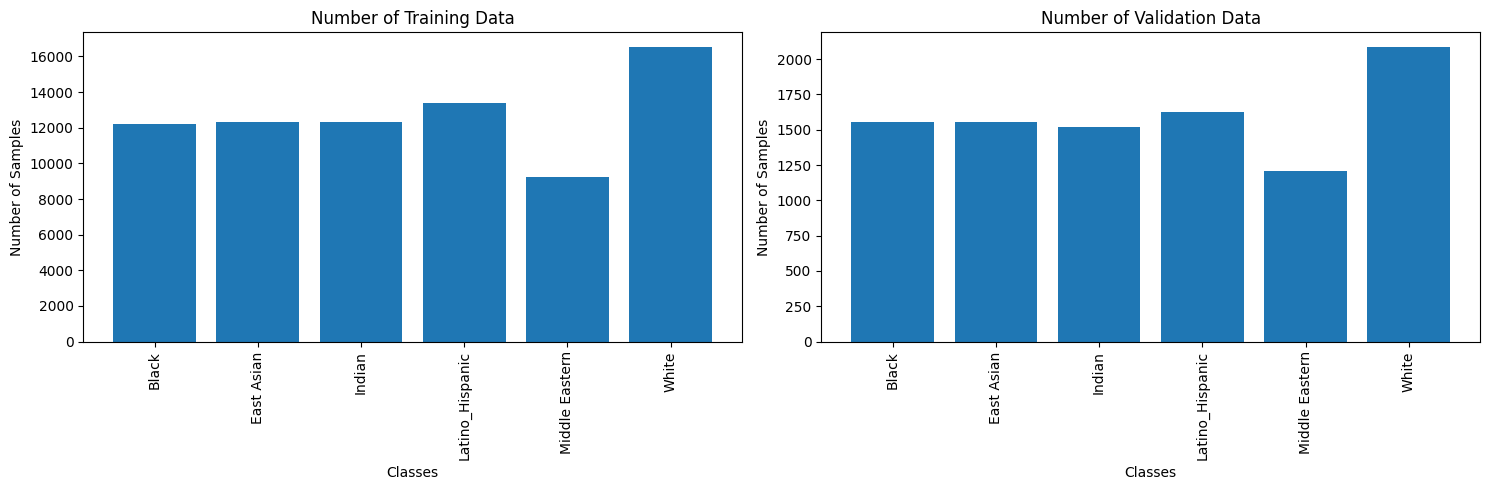

In [5]:
import os
import matplotlib.pyplot as plt

def count_files(directory):
    """
    Counts the number of files in each subdirectory of a given directory.
    Assumes that each subdirectory represents a class.
    """
    counts = []
    class_names = []
    # Walk through each subdirectory in the directory
    for subdir in sorted(os.listdir(directory)):
        path = os.path.join(directory, subdir)
        if os.path.isdir(path):
            # Count the number of files in this subdirectory
            num_files = len([file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))])
            counts.append(num_files)
            class_names.append(subdir)
    return counts, class_names

def plot_histogram(counts, class_names, title, ax):
    """
    Plots a histogram of the number of files for each class.
    """
    ax.bar(class_names, counts)
    ax.set_title(f'Number of {title} Data')
    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of Samples')
    ax.tick_params(axis='x', rotation=90)

# Directories
training_dir = './races_/Training'
validation_dir = './races_/Validation'
# test_dir = './races_/Test'

# Count files in each directory
training_counts, training_classes = count_files(training_dir)
validation_counts, validation_classes = count_files(validation_dir)
# test_counts, test_classes = count_files(test_dir)

# Plot histograms
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_histogram(training_counts, training_classes, 'Training', axs[0])
plot_histogram(validation_counts, validation_classes, 'Validation', axs[1])
# plot_histogram(test_counts, test_classes, 'Test', axs[2])

plt.tight_layout()
plt.show()

In [5]:
# Based on VGG16 architecture -> old paper(2015)
vggface = VGGFace(model='vgg16') # or VGGFace() as default

In [6]:
vggface.summary()

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [7]:
model_old = Sequential()

for layer in vggface.layers[:-6]:
    model_old.add(layer)

for layer in model_old.layers:
    layer.trainable = False
    
model_old.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0         
                                                                 
 conv3_1 (Conv2D)            (None, 56, 56, 256)       2

In [8]:
model = Sequential([
    Input(input_shape),
    model_old,
    # Flatten(),
    Dense(FC, activation='relu'),
    Dropout(dense_dropout),
    BatchNormalization(),
    Dense(FC, activation='relu'),
    Dropout(dense_dropout),
    BatchNormalization(),
    Dense(FC, activation='relu'),
    Dropout(dense_dropout),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 25088)             14714688  
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                      

In [9]:
model.compile(optimizer=Adam(adam_lr),
              loss=loss
              ,metrics=metrics)

In [10]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = patience,
                        verbose = verbose ,
                        factor = factor,
                        min_lr = min_lr)

mcp = ModelCheckpoint(model_name, monitor='val_accuracy', verbose=verbose, save_best_only=True, mode='max')

es = EarlyStopping(verbose=verbose, patience=patience)

In [11]:
# Check the accuracy of the model before training
# model = load_model(model_name)

print("Accuracy before training")
score = model.evaluate(validation_generator)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])


# Train the model
print("Training the model")
hist = model.fit(train_generator,
                  steps_per_epoch = train_generator.samples // batch_size,
                  validation_data = validation_generator, 
                  validation_steps = validation_generator.samples // batch_size,
                  epochs = epochs,
                  verbose = 1,
                  callbacks=[lrd, mcp])


# Check the accuracy of the model after training

print("Accuracy after training")
score = model.evaluate(validation_generator)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Accuracy before training
38/38 [==============================] - 23s 323ms/step - loss: 1.7925 - accuracy: 0.1551
Test Loss: 1.7924573421478271
Test Accuracy: 0.15507124364376068
Training the model
Epoch 1/120
296/296 [==============================] - ETA: 0s - loss: 1.5474 - accuracy: 0.4814
Epoch 1: val_accuracy improved from -inf to 0.59977, saving model to vggface_race.h5
296/296 [==============================] - 487s 2s/step - loss: 1.5474 - accuracy: 0.4814 - val_loss: 1.0325 - val_accuracy: 0.5998 - lr: 0.0010
Epoch 2/120
296/296 [==============================] - ETA: 0s - loss: 1.1846 - accuracy: 0.5451
Epoch 2: val_accuracy improved from 0.59977 to 0.61085, saving model to vggface_race.h5
296/296 [==============================] - 460s 2s/step - loss: 1.1846 - accuracy: 0.5451 - val_loss: 1.0042 - val_accuracy: 0.6109 - lr: 0.0010
Epoch 3/120
296/296 [==============================] - ETA: 0s - loss: 1.1255 - accuracy: 0.5645
Epoch 3: val_accuracy improved from 0.61085 to 

In [23]:
print(hist.history['accuracy'])
print(hist.history['val_accuracy'])
print(hist.history['loss'])
print(hist.history['val_loss'])

[0.4814442992210388, 0.5450751185417175, 0.5645157098770142, 0.5755698680877686, 0.5799545645713806, 0.5846298336982727, 0.5877862572669983, 0.5900050401687622, 0.5940067172050476, 0.5942840576171875, 0.5970046520233154, 0.5995668172836304, 0.5993291139602661, 0.6011252403259277, 0.6055495142936707, 0.6136981844902039, 0.6194167733192444, 0.6235637664794922, 0.6232995986938477, 0.6245410442352295, 0.6284371018409729, 0.6313161849975586, 0.6305898427963257, 0.6311973333358765, 0.6355159878730774, 0.6357669234275818, 0.6360178589820862, 0.6393327713012695, 0.63851398229599, 0.6403629183769226, 0.6400988101959229, 0.647956907749176, 0.6496341824531555, 0.6525132656097412, 0.6519189476966858, 0.6576111316680908, 0.6603713631629944, 0.6586148738861084, 0.6632900834083557, 0.6634485721588135, 0.6645843982696533, 0.6634485721588135, 0.6648881435394287, 0.6666446328163147, 0.66780686378479, 0.6678200960159302, 0.6691011190414429, 0.6673974394798279, 0.6714387536048889, 0.6707519888877869, 0.66

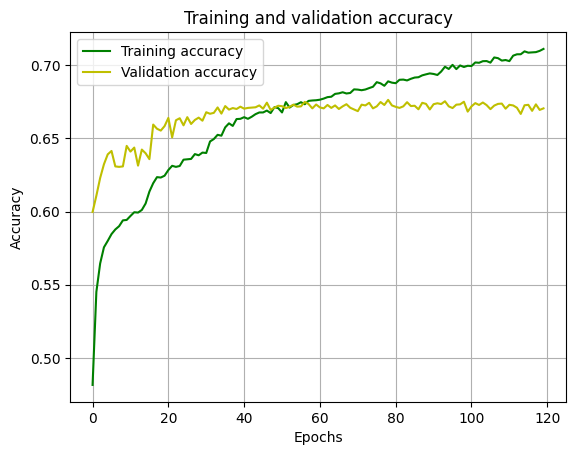

In [21]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

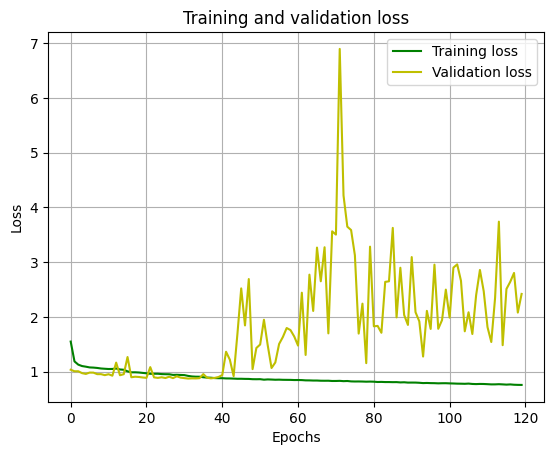

In [22]:
# plot loss curves
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()


In [9]:
train_accuracy = [0.4814442992210388, 0.5450751185417175, 0.5645157098770142, 0.5755698680877686, 0.5799545645713806, 0.5846298336982727, 0.5877862572669983, 0.5900050401687622, 0.5940067172050476, 0.5942840576171875, 0.5970046520233154, 0.5995668172836304, 0.5993291139602661, 0.6011252403259277, 0.6055495142936707, 0.6136981844902039, 0.6194167733192444, 0.6235637664794922, 0.6232995986938477, 0.6245410442352295, 0.6284371018409729, 0.6313161849975586, 0.6305898427963257, 0.6311973333358765, 0.6355159878730774, 0.6357669234275818, 0.6360178589820862, 0.6393327713012695, 0.63851398229599, 0.6403629183769226, 0.6400988101959229, 0.647956907749176, 0.6496341824531555, 0.6525132656097412, 0.6519189476966858, 0.6576111316680908, 0.6603713631629944, 0.6586148738861084, 0.6632900834083557, 0.6634485721588135, 0.6645843982696533, 0.6634485721588135, 0.6648881435394287, 0.6666446328163147, 0.66780686378479, 0.6678200960159302, 0.6691011190414429, 0.6673974394798279, 0.6714387536048889, 0.6707519888877869, 0.6678200960159302, 0.6748725771903992, 0.6711481809616089, 0.6729311347007751, 0.6734594106674194, 0.6748197078704834, 0.6734330058097839, 0.6757310032844543, 0.6760083436965942, 0.676166832447052, 0.6765366196632385, 0.6773025989532471, 0.6782931685447693, 0.6785705089569092, 0.6805118918418884, 0.680881679058075, 0.6816344857215881, 0.6807892322540283, 0.6811458468437195, 0.6836023330688477, 0.6834438443183899, 0.6830211877822876, 0.6835230588912964, 0.6844871640205383, 0.6853852272033691, 0.6885284781455994, 0.6877228617668152, 0.6860588192939758, 0.6890963912010193, 0.6881983280181885, 0.687828540802002, 0.6901529431343079, 0.6902981996536255, 0.6897171139717102, 0.6908264756202698, 0.6916849613189697, 0.6919094324111938, 0.6931905150413513, 0.6938905119895935, 0.6945244073867798, 0.6941414475440979, 0.6934546828269958, 0.6958054900169373, 0.6990808248519897, 0.6975488066673279, 0.7003750801086426, 0.6974695324897766, 0.6999656558036804, 0.6989091038703918, 0.6997411251068115, 0.6995562314987183, 0.7020127177238464, 0.7017881870269775, 0.7028843760490417, 0.702963650226593, 0.7018938660621643, 0.7054333090782166, 0.7049446702003479, 0.7032938003540039, 0.7036768198013306, 0.7029240131378174, 0.706661581993103, 0.7075992226600647, 0.707625687122345, 0.7096067070960999, 0.7087218165397644, 0.7089067101478577, 0.7090784311294556, 0.7099368572235107, 0.7112707495689392]
val_accuracy = [0.5997677445411682, 0.6108530163764954, 0.622994065284729, 0.6323902010917664, 0.6391469836235046, 0.6414695978164673, 0.630912184715271, 0.6305954456329346, 0.630912184715271, 0.6449535489082336, 0.6410472989082336, 0.6437922120094299, 0.6314400434494019, 0.6424197554588318, 0.6398859620094299, 0.6358741521835327, 0.6595228314399719, 0.6566722989082336, 0.6554054021835327, 0.6584670543670654, 0.6640625, 0.6507601141929626, 0.6624788641929626, 0.6638513803482056, 0.6589949131011963, 0.6645903587341309, 0.6599451303482056, 0.6626900434494019, 0.6642736196517944, 0.662162184715271, 0.66796875, 0.6669130325317383, 0.6675464510917664, 0.6712415814399719, 0.6670185923576355, 0.6721917390823364, 0.6697635054588318, 0.6708192825317383, 0.6701858043670654, 0.6717694401741028, 0.6703969836235046, 0.6709248423576355, 0.6711359620094299, 0.6713471412658691, 0.6726140379905701, 0.6703969836235046, 0.6745143532752991, 0.6695523858070374, 0.6711359620094299, 0.6724028587341309, 0.6720861196517944, 0.6708192825317383, 0.6716638803482056, 0.6731418967247009, 0.6717694401741028, 0.6719805598258972, 0.6750422120094299, 0.6735641956329346, 0.6706081032752991, 0.6732474565505981, 0.6712415814399719, 0.6706081032752991, 0.6729307174682617, 0.6709248423576355, 0.6726140379905701, 0.6701858043670654, 0.6719805598258972, 0.6734586358070374, 0.6710304021835327, 0.669869065284729, 0.6687077879905701, 0.6731418967247009, 0.6726140379905701, 0.6744087934494019, 0.6706081032752991, 0.6719805598258972, 0.6749366521835327, 0.6729307174682617, 0.6764146685600281, 0.6726140379905701, 0.6716638803482056, 0.6709248423576355, 0.6719805598258972, 0.6748310923576355, 0.6721917390823364, 0.6724028587341309, 0.669974684715271, 0.6744087934494019, 0.6736697554588318, 0.669869065284729, 0.6734586358070374, 0.6740920543670654, 0.6735641956329346, 0.6754645109176636, 0.6719805598258972, 0.6708192825317383, 0.6731418967247009, 0.6733530163764954, 0.6751478314399719, 0.6683910489082336, 0.6719805598258972, 0.6741976141929626, 0.6729307174682617, 0.6746199131011963, 0.6728251576423645, 0.6700802445411682, 0.6725084185600281, 0.6736697554588318, 0.673880934715271, 0.6703969836235046, 0.6730363368988037, 0.6726140379905701, 0.6710304021835327, 0.6668074131011963, 0.6727195978164673, 0.6730363368988037, 0.6689189076423645, 0.6733530163764954, 0.6695523858070374, 0.6706081032752991]
train_loss = [1.5474143028259277, 1.1845762729644775, 1.1254748106002808, 1.099557876586914, 1.0882338285446167, 1.0747370719909668, 1.0714706182479858, 1.0651735067367554, 1.0551245212554932, 1.0501933097839355, 1.0458042621612549, 1.0466736555099487, 1.054979920387268, 1.037584900856018, 1.0318849086761475, 1.0031583309173584, 0.985073447227478, 0.9856739044189453, 0.9818424582481384, 0.9743048548698425, 0.9676475524902344, 0.9584414958953857, 0.9589113593101501, 0.9589055180549622, 0.9528140425682068, 0.9506761431694031, 0.9496737718582153, 0.9379338622093201, 0.9402000904083252, 0.9369586110115051, 0.934300422668457, 0.919630765914917, 0.9096124172210693, 0.9053632616996765, 0.90495365858078, 0.8947901129722595, 0.8888699412345886, 0.8864108920097351, 0.8798413872718811, 0.8775166273117065, 0.8776772022247314, 0.8734695315361023, 0.8728249073028564, 0.8702787160873413, 0.8669736385345459, 0.8671636581420898, 0.865095853805542, 0.8642869591712952, 0.8595011234283447, 0.8587020039558411, 0.8598607778549194, 0.8505567908287048, 0.8554832935333252, 0.8529700636863708, 0.8494728803634644, 0.8511440753936768, 0.8482295274734497, 0.8474669456481934, 0.8467852473258972, 0.8438112139701843, 0.8444761633872986, 0.842870831489563, 0.838057279586792, 0.8372877240180969, 0.8348247408866882, 0.8347940444946289, 0.831413745880127, 0.8308277726173401, 0.831295907497406, 0.8267364501953125, 0.8269280791282654, 0.8291299343109131, 0.8236727118492126, 0.8264244198799133, 0.8192869424819946, 0.8173075318336487, 0.817976713180542, 0.816561758518219, 0.8139452338218689, 0.8156741857528687, 0.8136493563652039, 0.8081036806106567, 0.8099347949028015, 0.806991696357727, 0.8070021867752075, 0.8053240180015564, 0.8060250282287598, 0.8006892204284668, 0.8031679391860962, 0.7972420454025269, 0.7977522015571594, 0.7973986864089966, 0.7939357161521912, 0.7882726788520813, 0.79050612449646, 0.7876609563827515, 0.7866572737693787, 0.7835659980773926, 0.7854992747306824, 0.7858725190162659, 0.7828693985939026, 0.7808002233505249, 0.7780352234840393, 0.7769932150840759, 0.7751680016517639, 0.7789201736450195, 0.7723917961120605, 0.7698978781700134, 0.7727220058441162, 0.7716897130012512, 0.7683552503585815, 0.76445472240448, 0.7647824287414551, 0.7678679823875427, 0.7643691897392273, 0.760222852230072, 0.7639117240905762, 0.7580626606941223, 0.7555879354476929, 0.7546939849853516]
val_loss = [1.0324962139129639, 1.0041738748550415, 1.0045095682144165, 0.9700385332107544, 0.9558327198028564, 0.9801388382911682, 0.9791852831840515, 0.951723039150238, 0.951646625995636, 0.9335588216781616, 0.9501613974571228, 0.9235326647758484, 1.1626696586608887, 0.9318656921386719, 0.9507892727851868, 1.2650352716445923, 0.8952932357788086, 0.9043936729431152, 0.8999526500701904, 0.8907520174980164, 0.8839188814163208, 1.0801866054534912, 0.8926435112953186, 0.8833527565002441, 0.8946416974067688, 0.8808452486991882, 0.9050695896148682, 0.8786424398422241, 0.9122474193572998, 0.8883823752403259, 0.8790527582168579, 0.8709139227867126, 0.8748705983161926, 0.8737906217575073, 0.8781736493110657, 0.9522319436073303, 0.8863967657089233, 0.8746308088302612, 0.883198618888855, 0.8993541598320007, 0.9344714283943176, 1.361241340637207, 1.216367244720459, 0.915280818939209, 1.6871230602264404, 2.5198402404785156, 1.8427363634109497, 2.6906728744506836, 1.0438003540039062, 1.4300175905227661, 1.4936587810516357, 1.9462649822235107, 1.4787031412124634, 1.064126968383789, 1.1653788089752197, 1.503545880317688, 1.631523847579956, 1.7952501773834229, 1.7579807043075562, 1.6396452188491821, 1.473740816116333, 2.4409329891204834, 1.3025298118591309, 2.7711219787597656, 2.107428789138794, 3.2661027908325195, 2.6500537395477295, 3.272142171859741, 1.697070598602295, 3.563373565673828, 3.5036604404449463, 6.899031639099121, 4.219696044921875, 3.648613929748535, 3.5869863033294678, 3.1263856887817383, 1.6934870481491089, 2.240915298461914, 1.15274178981781, 3.2831592559814453, 1.8262916803359985, 1.834062099456787, 1.7083500623703003, 2.6391000747680664, 2.649576425552368, 3.626216173171997, 1.9896892309188843, 2.897555112838745, 2.0338897705078125, 1.8516396284103394, 3.0927140712738037, 2.0850296020507812, 1.9172656536102295, 1.2738368511199951, 2.1087424755096436, 1.778764247894287, 2.9542076587677, 1.7806396484375, 1.9395966529846191, 2.4973862171173096, 1.984863042831421, 2.8995120525360107, 2.959374189376831, 2.6587419509887695, 1.7354447841644287, 2.0836188793182373, 1.6858478784561157, 2.396761894226074, 2.8567895889282227, 2.4684159755706787, 1.8118441104888916, 1.539854645729065, 2.3459761142730713, 3.7404637336730957, 1.4813483953475952, 2.509657621383667, 2.640350580215454, 2.802387237548828, 2.0778121948242188, 2.4188127517700195]

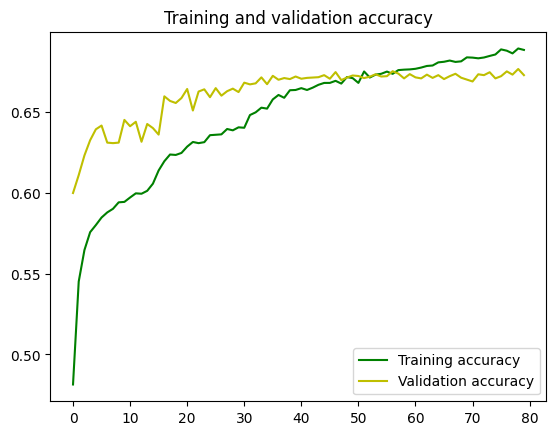

<Figure size 640x480 with 0 Axes>

In [12]:
epochs = range(len(train_accuracy) - 40)
plt.plot(epochs, train_accuracy[0:80], 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy[0:80], 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()


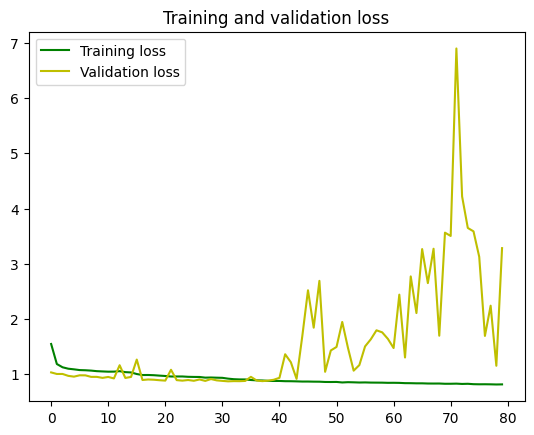

<Figure size 640x480 with 0 Axes>

In [13]:
plt.plot(epochs, train_loss[0:80], 'g', label='Training loss')
plt.plot(epochs, val_loss[0:80], 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [4]:
model = load_model('vggface_race_67_this.h5')

In [5]:
# Loading the model and testing it on a sample image
# print("Loading the model")
# model = load_model('model.h5')

print("Testing the model on a sample image")
# sample_img_path = './my_friends/cumali.jpeg'
sample_img_path = './my_friends/haluk.png'
# sample_img_path = './my_friends/cemre2.jpg'
# sample_img_path = './my_friends/bayzan.jpg'
# sample_img_path = './my_friends/engin.jpg'
# sample_img_path = './my_friends/halimcan.jpg'
# sample_img_path = './my_friends/halim2.jpeg'
# sample_img_path = './my_friends/cemre5.jpg'
# sample_img_path = './my_friends/engin2.jpg'
# sample_img_path = './my_friends/erto.jpg'
# sample_img_path = './my_friends/harry.jpg'
sample_img = tf.keras.preprocessing.image.load_img(sample_img_path, target_size=target_size)
sample_img = tf.keras.preprocessing.image.img_to_array(sample_img)
sample_img = np.expand_dims(sample_img, axis=0)
sample_img = sample_img/255
prediction = model.predict(sample_img)
print(prediction)
predicted_class = np.argmax(prediction)
if predicted_class == 0:
    print("Prediction is Black")
if predicted_class == 1:
    print("Prediction is East Asian")
if predicted_class == 2:
    print("Prediction is Indian")    
if predicted_class == 3:
    print("Prediction is Latino")  
if predicted_class == 4:
    print("Prediction is Middle Eastern")  
if predicted_class == 5:
    print("Prediction is White")  




Testing the model on a sample image
1/1 [==============================] - 4s 4s/step
[[0.00377544 0.02255272 0.00316288 0.17276219 0.09163424 0.7061125 ]]
Prediction is White


In [15]:
def id2label(id):
    if id == 0:
        return "Black"
    if id == 1:
        return "East Asian"
    if id == 2:
        return "Indian"    
    if id == 3:
        return "Latino"  
    if id == 4:
        return "Middle Eastern"  
    if id == 5:
        return "White"

In [16]:
validation_generator =  validation_data.flow_from_directory( './races_/Validation',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'categorical',
                                                          seed=seed,
                                                          target_size = target_size,
                                                          shuffle=False)

# Plotting some of the misclassified images with their true and predicted labels
print("Plotting some of the misclassified images with their true and predicted labels")
validation_generator.reset()
pred = model.predict(validation_generator)
pred = np.argmax(pred, axis=1)
print(pred)
print(validation_generator.classes)
print(validation_generator.class_indices)
print(validation_generator.filenames)
misclassified_idx = np.where(pred != validation_generator.classes)[0]
print("Number of misclassified samples = ", len(misclassified_idx))
print("Total number of samples = ", len(validation_generator.classes))
print("Percentage of misclassified samples = ", len(misclassified_idx)/len(validation_generator.classes)*100, "%")



Found 9544 images belonging to 6 classes.
Plotting some of the misclassified images with their true and predicted labels
38/38 [==============================] - 156s 4s/step
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
{'Black': 0, 'East Asian': 1, 'Indian': 2, 'Latino_Hispanic': 3, 'Middle Eastern': 4, 'White': 5}
['Black\\10006.jpg', 'Black\\10017.jpg', 'Black\\10024.jpg', 'Black\\10029.jpg', 'Black\\10033.jpg', 'Black\\10038.jpg', 'Black\\10040.jpg', 'Black\\10051.jpg', 'Black\\10052.jpg', 'Black\\1006.jpg', 'Black\\10060.jpg', 'Black\\10061.jpg', 'Black\\10068.jpg', 'Black\\10069.jpg', 'Black\\10076.jpg', 'Black\\10081.jpg', 'Black\\10096.jpg', 'Black\\10117.jpg', 'Black\\10136.jpg', 'Black\\10137.jpg', 'Black\\10138.jpg', 'Black\\10151.jpg', 'Black\\10159.jpg', 'Black\\10169.jpg', 'Black\\10171.jpg', 'Black\\10176.jpg', 'Black\\10180.jpg', 'Black\\10182.jpg', 'Black\\10186.jpg', 'Black\\1019.jpg', 'Black\\10190.jpg', 'Black\\10191.jpg', 'Black\\10199.jpg', 'Black\\1020.jpg', 'Black\\10203

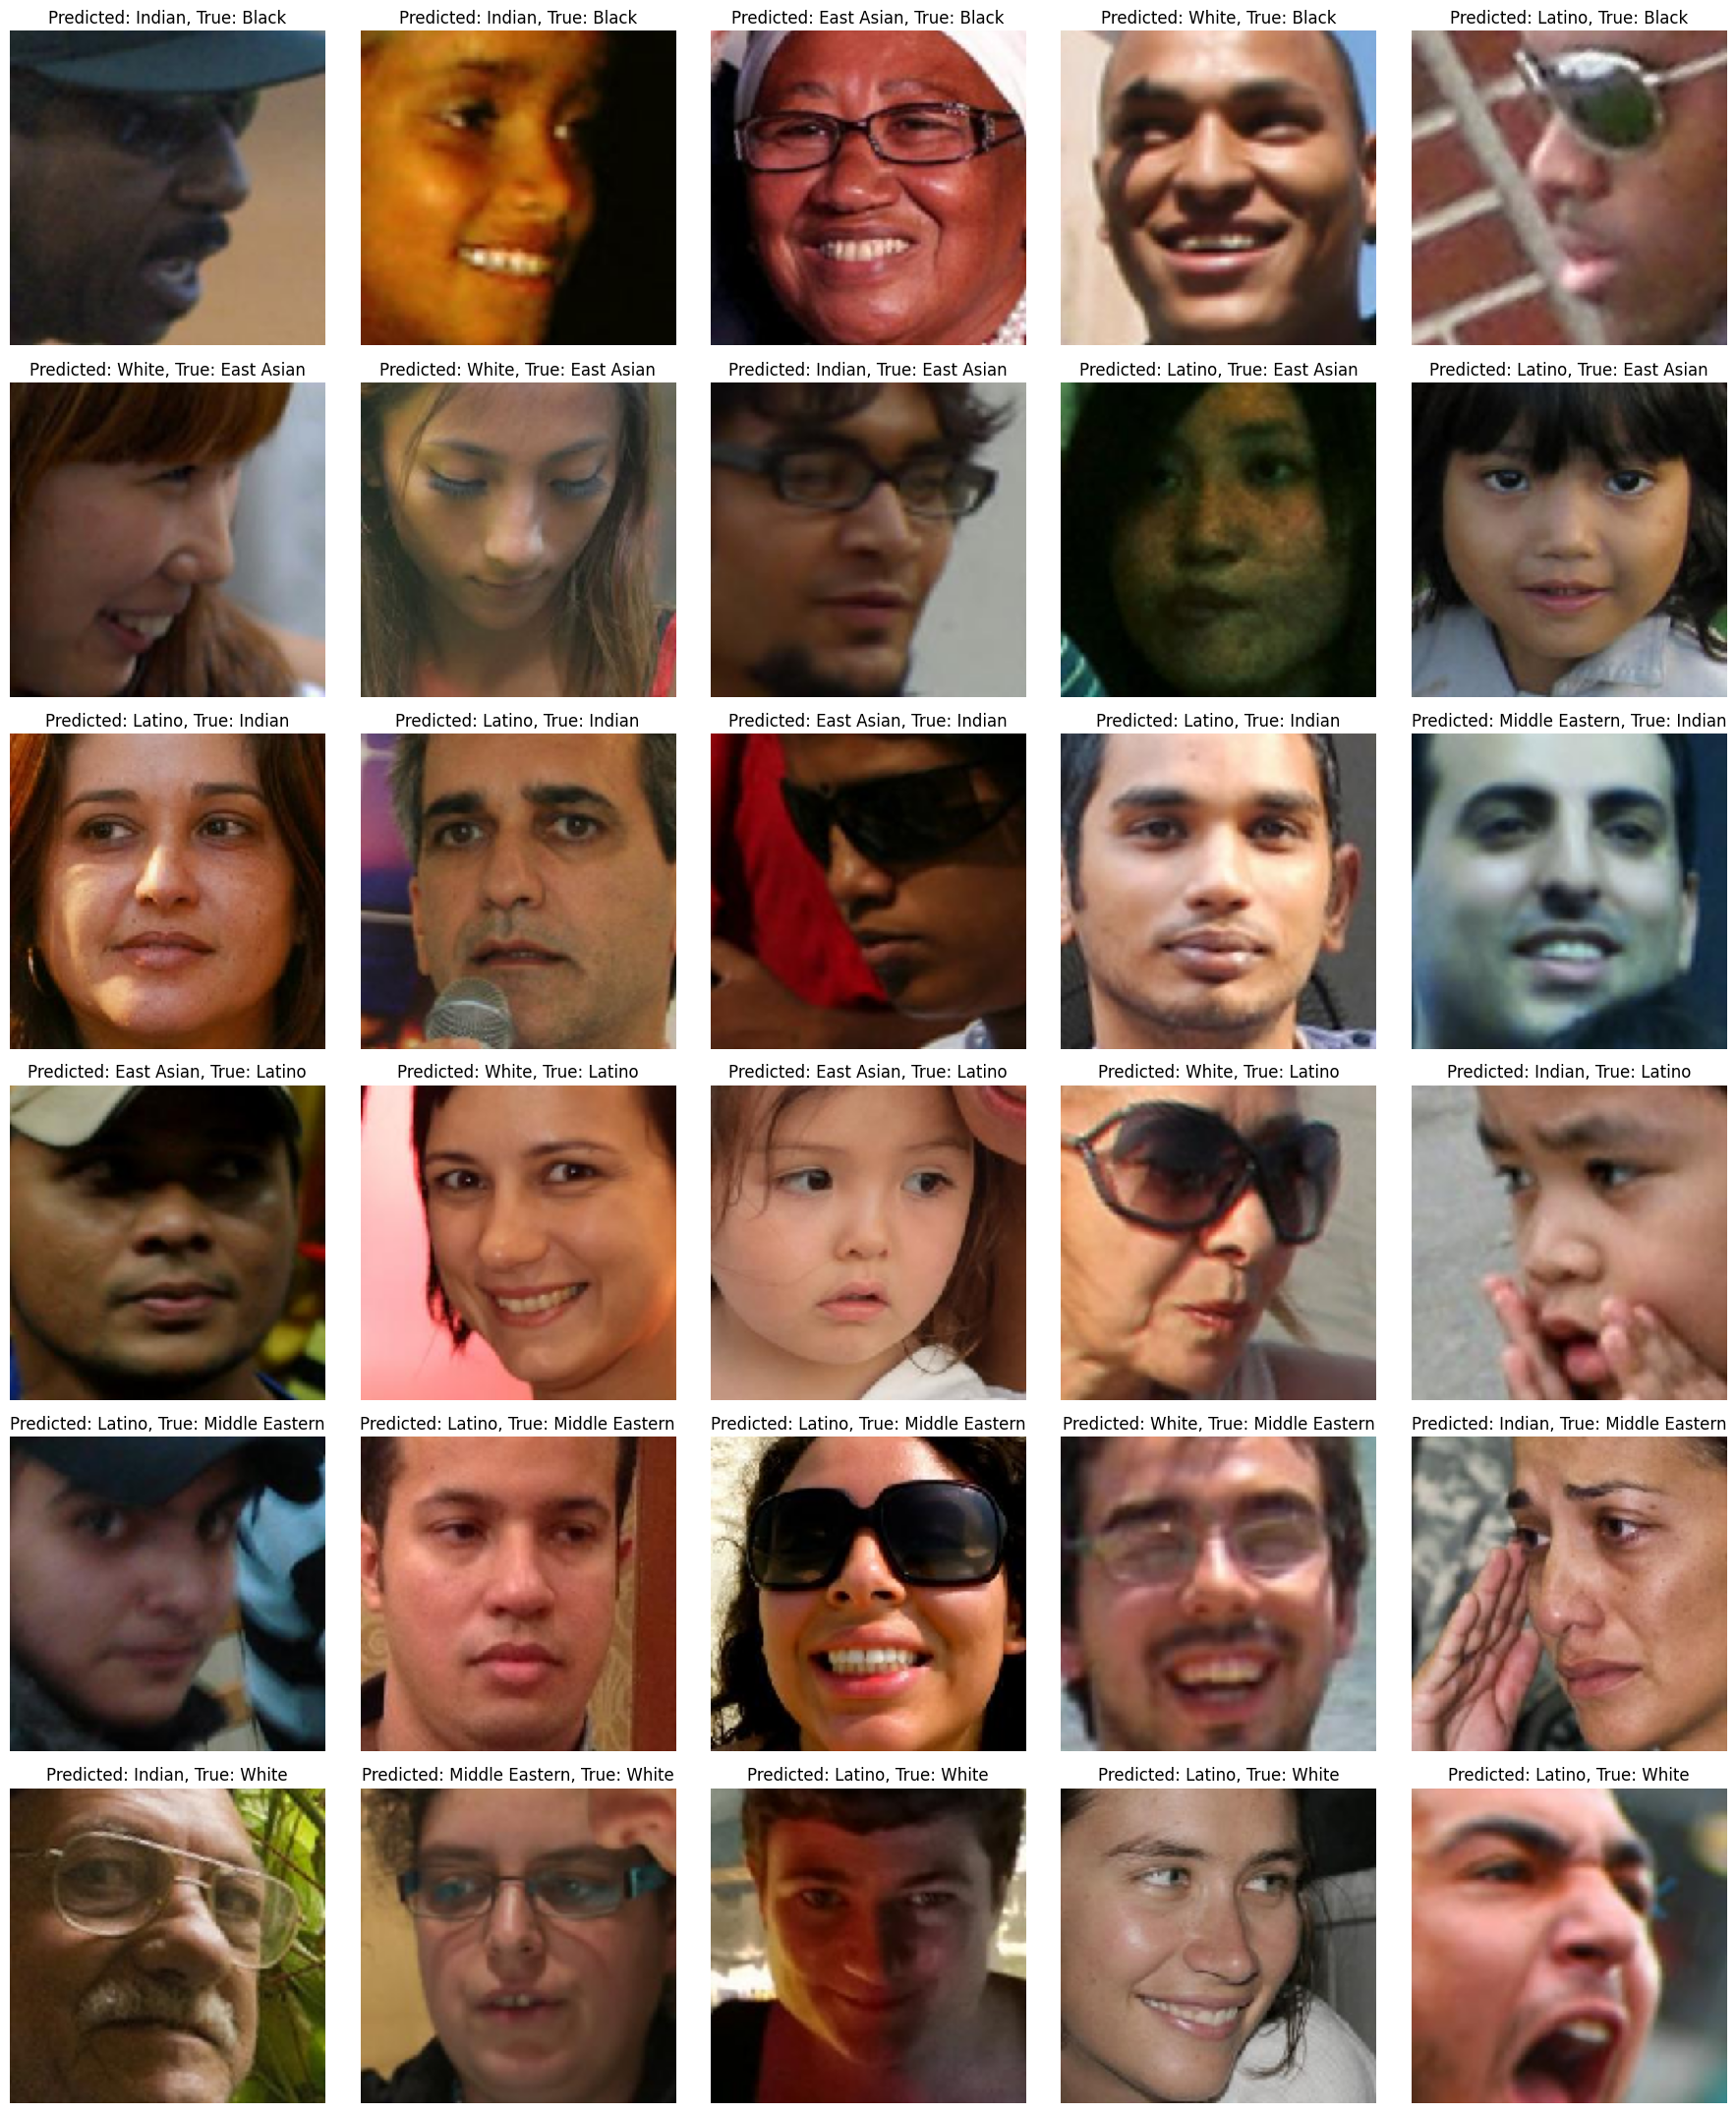

In [17]:
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ... [your previous code and function definitions] ...

def plot_misclassified_images(misclassified_idx, pred, true_labels, filenames, target_size=(150, 150)):
    # Number of classes and images per class to display
    num_classes = 6
    images_per_class = 5

    # Create a 6x5 grid for plotting
    fig, axes = plt.subplots(6, 5, figsize=(18, 21.6))  # Adjust the figsize if needed
    axes = axes.ravel()

    # Counters for misclassified images per class
    misclassified_counters = [0] * num_classes

    # Index for the subplot
    subplot_idx = 0

    for idx in misclassified_idx:
        true_label = true_labels[idx]
        if misclassified_counters[true_label] < images_per_class:
            misclassified_counters[true_label] += 1

            img_path = os.path.join(validation_generator.directory, filenames[idx])
            img = load_img(img_path, target_size=target_size)
            img = img_to_array(img)
            axes[subplot_idx].imshow(img.astype('uint8'))
            axes[subplot_idx].set_title(f"Predicted: {id2label(pred[idx])}, True: {id2label(true_label)}")
            axes[subplot_idx].axis('off')
            subplot_idx += 1

            # Break if all subplots are filled
            if subplot_idx >= num_classes * images_per_class:
                break

    # Hide any empty plots
    for i in range(subplot_idx, num_classes * images_per_class):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

plot_misclassified_images(misclassified_idx, pred, validation_generator.classes, validation_generator.filenames)

{'Black': 0, 'East Asian': 1, 'Indian': 2, 'Latino_Hispanic': 3, 'Middle Eastern': 4, 'White': 5}
38/38 [==============================] - 12s 308ms/step
                 precision    recall  f1-score   support

          Black       0.83      0.81      0.82      1556
     East Asian       0.82      0.81      0.82      1555
         Indian       0.65      0.67      0.66      1516
Latino_Hispanic       0.48      0.51      0.49      1623
 Middle Eastern       0.56      0.54      0.55      1209
          White       0.71      0.68      0.70      2085

       accuracy                           0.68      9544
      macro avg       0.67      0.67      0.67      9544
   weighted avg       0.68      0.68      0.68      9544



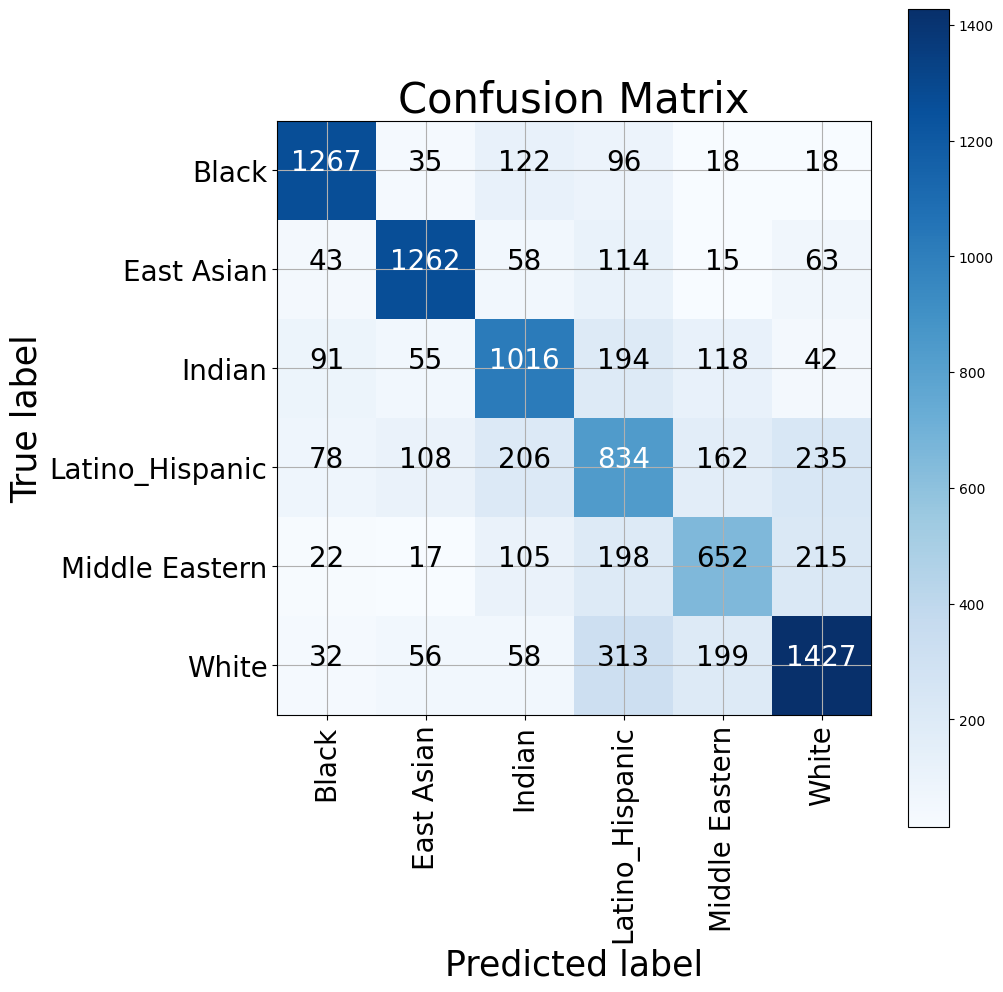

In [11]:
# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
    
    
        plt.figure(figsize=(10,10))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title, fontsize=30)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=90, fontsize=20)
        plt.yticks(tick_marks, classes, fontsize=20)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
    
        # Labeling the plot
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            # plt.text(j, i, format(cm[i, j], fmt), fontsize=20,
            plt.text(j, i, format(cm[i, j], fmt), fontsize=20,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', fontsize=25)
        plt.xlabel('Predicted label', fontsize=25)

# Get the labels of the test images.
test_labels = validation_generator.classes

# We need these to plot the confusion matrix.
test_labels

# Print the label associated with each class
print(validation_generator.class_indices)

# Generate predictions
predictions = model.predict(validation_generator, steps=validation_generator.samples // batch_size+1, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == test_labels)[0]
incorrect_indices = np.nonzero(predicted_classes != test_labels)[0]

# Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
cm = confusion_matrix(test_labels, predicted_classes)
cm_plot_labels = validation_generator.class_indices.keys()
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# Print the classification report
from sklearn.metrics import classification_report
# Generate a classification report

report = classification_report(test_labels, predicted_classes, target_names=validation_generator.class_indices.keys())

print(report)

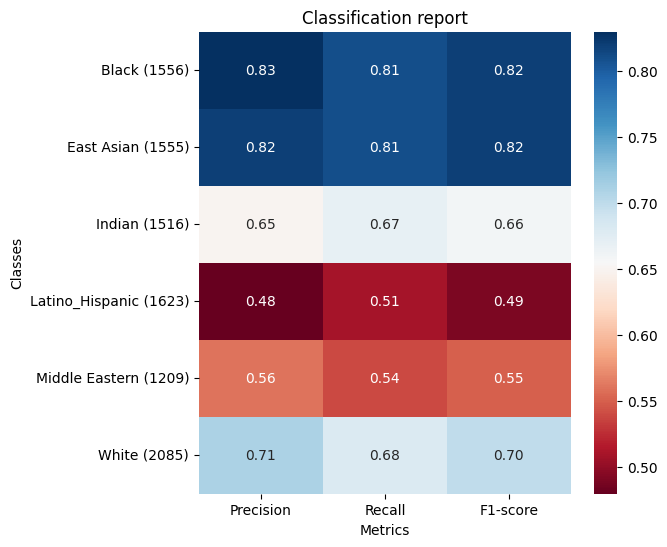

In [21]:

# Plot the classification report
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_classification_report(classificationReport,
                                 title='Classification report',
                                 cmap='RdBu'):
     '''
     Plot scikit-learn classification report.
     Extension based on https://stackoverflow.com/a/31689645/395857
     '''
     classificationReport = classificationReport.replace('\n\n', '\n')
     classificationReport = classificationReport.replace(' / ', '/')
     lines = classificationReport.split('\n')
    
     classes, plotMat, support, class_names = [], [], [], []
     for line in lines[1:-4]:  # if you don't want avg/total result, then change [1:] into [1:-1]
          t = line.strip().split()
          if len(t) < 2:
                continue
          if (t[0] == "East" and t[1] == "Asian" ) or (t[0] == "Middle" and t[1] == "Eastern"):
               classes.append(t[0] + " " + t[1])
               v = [float(x) for x in t[2: len(t) - 1]]
               support.append(int(t[-1]))
               class_names.append(t[0] + " " + t[1])
               plotMat.append(v)
               continue

          classes.append(t[0])
          v = [float(x) for x in t[1: len(t) - 1]]
          support.append(int(t[-1]))
          class_names.append(t[0])
          plotMat.append(v)
    
     plotMat = np.array(plotMat[0:6])
     xticklabels = ['Precision', 'Recall', 'F1-score']
     yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                     for idx, sup in enumerate(support)]
    
     plt.figure(figsize=(6, 6))
     sns.heatmap(plotMat, xticklabels=xticklabels,
                 yticklabels=yticklabels, cmap=cmap, annot=True, fmt='.2f')
     plt.title(title)
     plt.ylabel('Classes')
     plt.xlabel('Metrics')
     plt.savefig('classification_report.png')
     plt.show()

plot_classification_report(report)

Testing on our dataset

In [1]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D, Dropout
from tensorflow.keras.utils import plot_model
from keras.layers import BatchNormalization
from keras.optimizers import Adam
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pandas as pd
from keras_vggface.vggface import VGGFace
from keras.layers import Input
from mtcnn.mtcnn import MTCNN

In [2]:
batch_size = 256
target_size = (224, 224)
input_shape=(224, 224, 3)
epochs=50
seed=1337

In [3]:
train_data = ImageDataGenerator(rescale = 1./255,
      rotation_range=25,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_data = ImageDataGenerator( rescale = 1.0/255)

test_data = ImageDataGenerator( rescale = 1.0/255)

In [4]:
print("Loading the model")
model = load_model('vggface_race_67_this.h5')

Loading the model


In [5]:
# Plotting some of the misclassified images with their true and predicted labels
# print("Plotting some of the misclassified images with their true and predicted labels")
test_generator = test_data.flow_from_directory('./our_dataset/race',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'categorical',
                                                          seed=seed,
                                                          target_size = target_size,
                                                          shuffle=False)
test_generator.reset()
pred = model.predict(test_generator)
pred = np.argmax(pred, axis=1)
print(pred)
print(test_generator.classes)
print(test_generator.class_indices)
print(test_generator.filenames)
misclassified_idx = np.where(pred != test_generator.classes)[0]
# Labels of the misclassified images
misclassified_labels = test_generator.classes[misclassified_idx]
print("Number of misclassified samples = ", len(misclassified_idx))
print("Total number of samples = ", len(test_generator.classes))
print("Percentage of misclassified samples = ", len(misclassified_idx)/len(test_generator.classes)*100, "%")


Found 56 images belonging to 6 classes.
1/1 [==============================] - 6s 6s/step
[0 0 0 0 3 0 3 0 0 0 5 0 0 1 1 1 1 1 1 1 2 5 2 0 1 2 0 2 1 5 5 3 4 3 2 2 4
 3 4 3 5 4 3 5 5 5 5 5 5 3 5 4 5 0 5 5]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 4 4 4 4 4
 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
{'Black': 0, 'East Asian': 1, 'Indian': 2, 'Latino_Hispanic': 3, 'Middle Eastern': 4, 'White': 5}
['Black\\12312412.jpg', 'Black\\123334.jpg', 'Black\\8e516cbc55d6fa2e793d587c409a6cd6.jpg', 'Black\\asdawas.jpg', 'Black\\askdjajw�ojasd.jpg', 'Black\\b27a418cf6849a21dfba046d8db11c34.jpg', 'Black\\depositphotos_362165928-stock-photo-sad-man-sitting-dark-room.jpg', 'Black\\download.jpg', 'Black\\huy�ouhpn.jpg', 'Black\\lkajsdljadsas.jpg', 'Black\\oaspodjad.jpg', 'Black\\od�j�joas.jpg', 'Black\\oq�wjajsdaca.jpg', 'East Asian\\72ca897397cc1d901e52ae1757ddf5c4.jpg', 'East Asian\\asdkwoa.jpg', 'East Asian\\ef2a7da6ea5d46af839049c006bf3097.jpeg', 'East Asian\\j�ojjajscmasoc�m.jpg'